In [1]:
import pymongo
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance', 'bnb_usdt.spot:binance', 'ltc_usdt.spot:binance','bch_usdt.spot:binance',
             'doge_usdt.spot:binance', 'matic_usdt.spot:binance', 'sol_usdt.spot:binance','link_usdt.spot:binance','uni_usdt.spot:binance']
client = pymongo.MongoClient('172.16.20.81', 27017)

In [3]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [4]:
startTime = datetime(2022,11,13)
endTime = datetime(2023,1,31, 10)
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [5]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName],
                'bnb':readDb(dbClient[symbolList[2]], start=startTime , end=endTime)[columnsName],
                'ltc':readDb(dbClient[symbolList[3]], start=startTime , end=endTime)[columnsName],
                'bch':readDb(dbClient[symbolList[4]], start=startTime , end=endTime)[columnsName],
                'doge':readDb(dbClient[symbolList[5]], start=startTime , end=endTime)[columnsName],
                'matic':readDb(dbClient[symbolList[6]], start=startTime , end=endTime)[columnsName],
                'sol':readDb(dbClient[symbolList[7]], start=startTime , end=endTime)[columnsName],
                'link':readDb(dbClient[symbolList[8]], start=startTime , end=endTime)[columnsName],
                'uni':readDb(dbClient[symbolList[9]], start=startTime , end=endTime)[columnsName],
            }

In [6]:
def resampleDf(data, freq='H'):
    dataDf = df.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [7]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [8]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [9]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [10]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [11]:
multiDf.tail(10)

open        high          low        close  \
datetime            symbol                                                      
2023-01-31 09:00:00 bch       131.70000    133.3000    131.40000    132.90000   
                    bnb       307.50000    310.7000    307.30000    309.90000   
                    btc     22828.32000  22862.0000  22755.23000  22830.23000   
                    doge        0.08979      0.0925      0.08914      0.09071   
                    eth      1570.41000   1574.9900   1563.36000   1569.99000   
                    link        6.95300      6.9970      6.92200      6.97800   
                    ltc        93.50000     94.4600     93.43000     93.91000   
                    matic       1.09330      1.0961      1.08370      1.09180   
                    sol        23.95000     24.2300     23.80000     24.19000   
                    uni         6.53600      6.5800      6.50600      6.55400   

                                  volume  
datetime            symbol                
2023-01-31 09:00:00 bch     3.002146e+03  
                    bnb     1.900034e+04  
                    btc     8.455545e+03  
                    doge    2.494770e+08  
                    eth     1.616629e+04  
                    link    1.137229e+05  
                    ltc     8.814817e+04  
                    matic   3.150926e+06  
                    sol     2.113326e+05  
                    uni     4.641766e+04

In [12]:
periodList = [24, 72, 120, 192, 312]
symbolCount = 10

In [13]:
highPrice = multiDf['high'].unstack()
lowPrice = multiDf['low'].unstack()
closePrice = multiDf['close'].unstack()

In [14]:
btcStochasticDict = {}
for hour in periodList:
    btcStochasticDict[hour] = (closePrice['btc'] - closePrice['btc'].rolling(hour).min())/(closePrice['btc'].rolling(hour).max() - closePrice['btc'].rolling(hour).min())    
btcStochastic = pd.DataFrame(btcStochasticDict)
btcStochastic.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

## Code of Breadth Indicator

In [15]:
def cal_pt(positive, total):
    return positive/total

def cal_pnPct(positive, negative):
    return (positive/(positive+negative)).fillna(0)

def sumrows(frame):
    return frame.sum(axis=1)

# 1. Percent/Number of Stocks above Moving Average (Trend)

In [16]:
def cal_ma(data, timeperiod):
    return data.rolling(timeperiod).mean()
maPeriodDict = {}
for hour in periodList:
    ma = cal_ma(closePrice, hour)
    maPeriodDict[hour] = cal_pt(sumrows(closePrice>ma), symbolCount)
maUpPct = pd.DataFrame(maPeriodDict)
maUpPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# 2. Percent/Number of Stocks above Relative Strength

In [17]:
def cal_pct(data, period):
    return data.pct_change(period)
rsDf = pd.DataFrame({name: closePrice[name]/closePrice['btc'] for name in closePrice.columns})
rsDf['btc'] = closePrice['btc']
rsPeriodDict = {}
for hour in periodList:
    rsPeriodDict[hour] = cal_pt(sumrows(cal_pct(rsDf, hour)>0), symbolCount)
rsUpPct = pd.DataFrame(rsPeriodDict)
rsUpPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# 3. Periodic High and Low

In [18]:
import numpy as np
def cal_shochastic(data, period):
    return ((data - data.rolling(period).min())/(data.rolling(period).max()-data.rolling(period).min()))*100
hlRangePeriodDict = {}
for hour in periodList:
    hlRangePeriodDict[hour] = cal_pnPct(sumrows(cal_shochastic(closePrice, hour)>80), 
                                     sumrows(cal_shochastic(closePrice, hour)<20))
hlRangePct = pd.DataFrame(hlRangePeriodDict)
hlRangePct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# 4. Advance/Decline(Participation)

In [19]:
def cal_pct(data, period):
    return data.pct_change(period)
adPeriodDict = {}
for hour in periodList:
    adPeriodDict[hour] = cal_pt(sumrows(cal_pct(closePrice, hour)>0), symbolCount)
adPct = pd.DataFrame(adPeriodDict)
adPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# 5. Net New High and Net New Lows(Leadership)

In [20]:
hlNewPeriodDict = {}
for hour in periodList:
    dh = highPrice.rolling(hour).max().pct_change()
    dl = lowPrice.rolling(hour).min().pct_change()
    hlNewPeriodDict[hour] = cal_pnPct(sumrows(dh>0), sumrows(dl<0))
hlNewPct = pd.DataFrame(hlNewPeriodDict)
hlNewPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

In [21]:
hlNewPct.tail(20)

,1Day,3Day,5Day,8Day,13Day
datetime,,,,,
2023-01-30 14:00:00,0.0,0.0,0.0,0.0,0.0
2023-01-30 15:00:00,0.0,0.0,0.0,0.0,0.0
2023-01-30 16:00:00,0.0,0.0,0.0,0.0,0.0
2023-01-30 17:00:00,0.0,0.0,0.0,0.0,0.0
2023-01-30 18:00:00,0.0,0.0,0.0,0.0,0.0
2023-01-30 19:00:00,0.0,0.0,0.0,0.0,0.0
2023-01-30 20:00:00,0.0,0.0,0.0,0.0,0.0
2023-01-30 21:00:00,0.0,0.0,0.0,0.0,0.0
2023-01-30 22:00:00,0.0,0.0,0.0,0.0,0.0


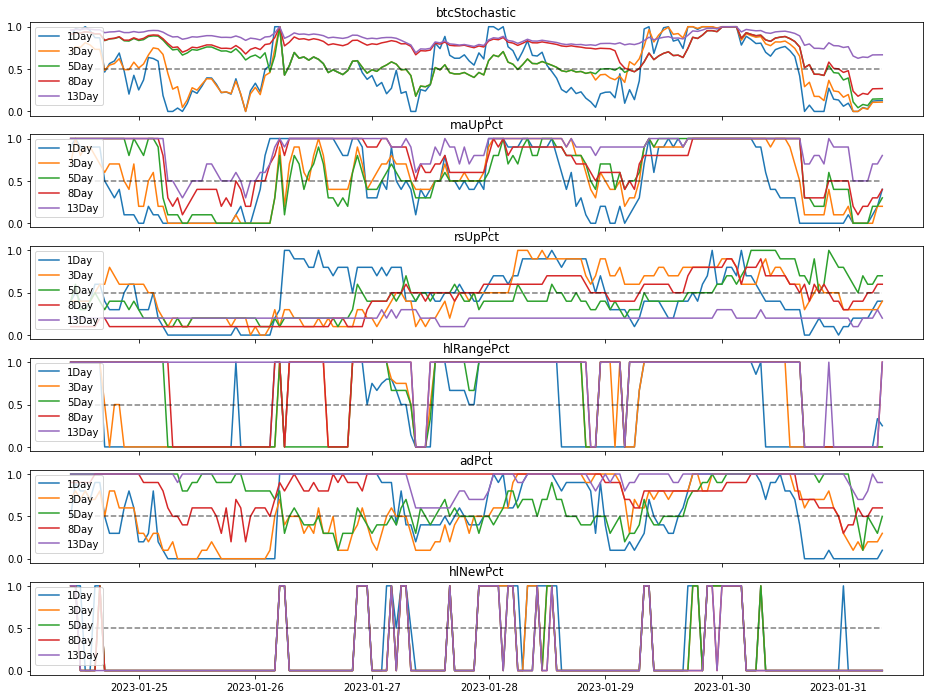

In [27]:
weeklyHour = 168
import matplotlib.pyplot as plt
fig, (ax, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, 1,sharex=True, figsize=(16,12))
ax.plot(btcStochastic.iloc[-weeklyHour:], label=btcStochastic.columns)
ax.hlines(0.5, btcStochastic.index[-weeklyHour],btcStochastic.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax.set_title('btcStochastic')
ax.legend(loc='upper left')
ax1.plot(maUpPct.iloc[-weeklyHour:], label=maUpPct.columns)
ax1.hlines(0.5, maUpPct.index[-weeklyHour],maUpPct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax1.set_title('maUpPct')
ax1.legend(loc='upper left')
ax2.plot(rsUpPct.iloc[-weeklyHour:], label=rsUpPct.columns)
ax2.hlines(0.5, rsUpPct.index[-weeklyHour],rsUpPct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax2.set_title('rsUpPct')
ax2.legend(loc='upper left')
ax3.plot(hlRangePct.iloc[-weeklyHour:], label=hlRangePct.columns)
ax3.hlines(0.5, hlRangePct.index[-weeklyHour], hlRangePct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax3.set_title('hlRangePct')
ax3.legend(loc='upper left')
ax4.plot(adPct.iloc[-weeklyHour:], label=adPct.columns)
ax4.hlines(0.5, adPct.index[-weeklyHour], adPct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax4.set_title('adPct')
ax4.legend(loc='upper left')
ax5.plot(hlNewPct.iloc[-weeklyHour:], label=hlNewPct.columns)
ax5.hlines(0.5, hlNewPct.index[-weeklyHour], hlNewPct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax5.set_title('hlNewPct')
ax5.legend(loc='upper left')
fig.savefig('best5Breadth')

In [23]:
def cal_weeklyPctChange(frame, columnsName, hours=168):
    diffChange = round(frame.diff(hours).iloc[-1], 3)
    diffChangeDf = diffChange.to_frame()
    diffChangeDf.columns = [columnsName]
    diffChangeDfT = diffChangeDf.T
    diffChangeDfT['avg'] = round(diffChangeDfT.mean(axis=1), 3)
    return diffChangeDfT

In [24]:
btcStochasticWeeklyDiff = cal_weeklyPctChange(btcStochastic, 'btcStochasticWeeklyDiff')
maUpWeeklyDiff = cal_weeklyPctChange(maUpPct, 'maUpWeeklyDiff')
rsUpWeeklyDiff = cal_weeklyPctChange(rsUpPct, 'rsUpWeeklyDiff')
hlNewWeeklyDiff = cal_weeklyPctChange(hlNewPct, 'hlNewWeeklyDiff')
adWeeklyDiff = cal_weeklyPctChange(adPct, 'adWeeklyDiff')
hlRangeWeeklyDiff = cal_weeklyPctChange(hlRangePct, 'hlRangeWeeklyDiff')

In [25]:
weeklyDiffDf = pd.concat([btcStochasticWeeklyDiff, maUpWeeklyDiff, rsUpWeeklyDiff, hlRangeWeeklyDiff, adWeeklyDiff, hlNewWeeklyDiff])

In [26]:
weeklyDiffDf.to_excel('breadthDiffChange.xlsx')